In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import torch.nn as nn

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset  = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [3]:
mnist_valid_dataset = Subset(mnist_dataset,torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset,torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root='./data', train=False,transform=transform, download=False)
print('number of items in mnist_dataset:', len(mnist_dataset))
print('number of items in mnist_train_dataset:', len(mnist_train_dataset))
print('number of items in mnist_valid_dataset:', len(mnist_valid_dataset))
print('number of items in mnist_test_dataset:', len(mnist_test_dataset))

number of items in mnist_dataset: 60000
number of items in mnist_train_dataset: 50000
number of items in mnist_valid_dataset: 10000
number of items in mnist_test_dataset: 10000


In [89]:
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

In [98]:
model = nn.Sequential()


#model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=24, kernel_size=3, stride=1, padding='valid'))
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=24, kernel_size=3, stride=1, padding='valid'))
#model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding='valid'))
#model.add_module('relu1', nn.ReLU())
model.add_module('leakyrelu1', nn.LeakyReLU())

#model.add_module('pool1', nn.MaxPool2d(kernel_size=2, stride=2))
model.add_module('pool1', nn.AvgPool2d(kernel_size=2, stride=2))


#model.add_module('conv2', nn.Conv2d(in_channels=24, out_channels=32, kernel_size=3, stride=3, padding='valid'))
model.add_module('conv2', nn.Conv2d(in_channels=24, out_channels=32, kernel_size=3, stride=3, padding='valid'))
#model.add_module('conv2', nn.Conv2d(in_channels=4, out_channels=2, kernel_size=3, stride=3, padding='valid'))
#model.add_module('relu2', nn.ReLU())
model.add_module('leakyrelu2', nn.LeakyReLU())

#model.add_module('pool2', nn.MaxPool2d(kernel_size=4, stride=4))
model.add_module('pool2', nn.AvgPool2d(kernel_size=2, stride=2))

model.add_module('flatten', nn.Flatten())
x = torch.ones((4, 1, 28, 28))
print(model(x).shape)
model.add_module('fc1', nn.Linear(128, 10))
#model.add_module('fc1', nn.Linear(2, 10))
#model.add_module('fc1', nn.Linear(8, 10))


torch.Size([4, 128])


In [99]:
def train(model, num_epochs, train_dl, valid_dl): 
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    train_accu = []
    train_losses = []
    valid_accu = []
    valid_losses = []
    for epoch in range(num_epochs):
        total = 0
        correct = 0 
        running_loss = 0
        total_v = 0
        correct_v = 0 
        running_loss_v = 0

        model.train()
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            running_loss += loss.item()
            _, predicted = pred.max(1)
            total += y_batch.size(0)
            correct += predicted.eq(y_batch).sum().item()
       
        train_loss=running_loss/len(train_dl)
        accu=100.*correct/total
        print(accu)
        train_accu.append(accu)
        train_losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                
                
                running_loss_v += loss.item()
                _, preds_v = pred.max(1)
                total_v += y_batch.size(0)
                correct_v += preds_v.eq(y_batch).sum().item()
       
        valid_loss=running_loss_v/len(valid_dl)
        accu_v=100.*correct_v/total_v
        valid_accu.append(accu_v)
        valid_losses.append(valid_loss)

    return train_accu, train_losses, valid_accu, valid_losses

In [100]:
torch.manual_seed(1)
num_epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
[train_accu, train_losses, valid_accu, valid_losses] = train(model, num_epochs, train_dl, valid_dl)

72.776
90.974
93.318
94.182
94.918
95.162
95.456
95.722
95.97
96.22


In [101]:
print(train_accu)

[72.776, 90.974, 93.318, 94.182, 94.918, 95.162, 95.456, 95.722, 95.97, 96.22]


In [102]:
print(train_losses)

[0.889365501130176, 0.3163612444058556, 0.22905718373215717, 0.19577752809752436, 0.17450618132701157, 0.16037031278357178, 0.14891427335427013, 0.14058591085760033, 0.13358520009957464, 0.12524385402060073]


In [103]:
print(valid_accu)

[88.9, 91.33, 93.74, 94.06, 94.55, 95.16, 95.6, 95.55, 95.62, 95.66]


In [104]:
print(valid_losses)

[0.40193325523168416, 0.2906796770751666, 0.21351555528439534, 0.18934371968387229, 0.1767588679079607, 0.16165880473318753, 0.15113910555151427, 0.1535018594567753, 0.14398400072649026, 0.1522257595388278]


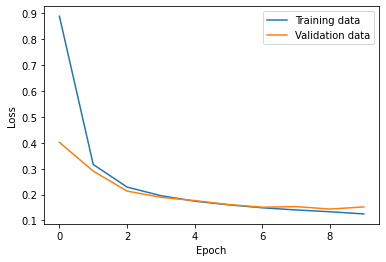

In [109]:
import matplotlib.pyplot as plt
plt.plot(range(10), train_losses, label = "Training data")
plt.plot(range(10), valid_losses, label = "Validation data")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

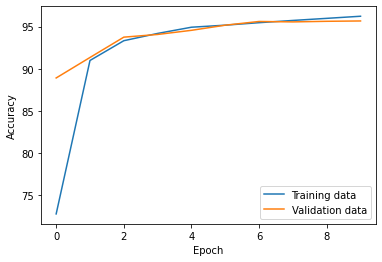

In [111]:
import matplotlib.pyplot as plt
plt.plot(range(10), train_accu, label = "Training data")
plt.plot(range(10), valid_accu, label = "Validation data")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()